In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.linalg import pinv
import matplotlib.pyplot as plt
import scipy.stats as stats

# Seed the random number generator to make the results reproducible
np.random.seed(42)

# Load the dataset
DKI1 = pd.read_excel("Forecast.xlsx", sheet_name="DKI1")  
DKI1A = pd.read_excel("VALIDASI.xlsx", sheet_name="DKI1")  
X = DKI1.index.values.reshape(-1, 1)
y = DKI1['PM10'].values.reshape(-1,)

# Define the forecast horizon
forecast_horizon = 31

In [31]:
# Making Train-Test Splits and Data Normalisation
m = 14
per = (0.7 * (len(X) - forecast_horizon) - m) / (len(X) - forecast_horizon)
size = int(len(X) * per)
X_train, X_test = X[0:size], X[size:len(X)]
y_train, y_test = y[0:size], y[size:len(y)]
mean_train = np.mean(y_train)
sd_train = np.std(y_train)
y_train = (y_train - mean_train) / sd_train
y_test = (y_test - mean_train) / sd_train

# Combine train and test data
X_data, y_data = np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test))

In [32]:
# Reshape the data into the form that needs to be fed into the ELM
def reshape_data(data, m):
    X_data, y_data = [], []
    for i in range(len(data) - m):
        X_data.append(data[i:i + m])
        y_data.append(data[i + m])
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    return X_data, y_data

X_data, y_data = reshape_data(y_data, m)


In [33]:
# Building the ELM model
input_size = X_data.shape[1]
hidden_size = 750  # no. of hidden neurons
mu, sigma = 0, 1
w_lo = -1
w_hi = 1
b_lo = -1
b_hi = 1

# Initializing input weights and biases randomly drawn from a truncated normal distribution
input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,
                                    size=[input_size, hidden_size])
biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,
                             size=[hidden_size])


def elu(x):
    alpha = 1.0  # ELU hyperparameter (can be adjusted)
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = elu(G)
    return H

output_weights = np.dot(pinv(hidden_nodes(X_data)), y_data)

def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out



In [34]:
# Make predictions for the forecast horizon
X_forecast = X_data[-1:, :]
forecast = []
for _ in range(forecast_horizon):
    prediction = predict(X_forecast)
    forecast.append(prediction)
    # Update X_forecast with the predicted value for the next iteration
    X_forecast = np.concatenate((X_forecast[:, 1:], prediction.reshape(1, 1)), axis=1)

# Denormalize the forecasted values
forecast = np.array(forecast)
forecast = (forecast * sd_train) + mean_train


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Mengubah data aktual ke dalam bentuk semula (sebelum dinormalisasi)
y_actual = DKI1A['PM10']
# Calculate evaluation metrics
rmse = math.sqrt(mean_squared_error(y_actual, forecast))
mse = mean_squared_error(y_actual, forecast)
mae = mean_absolute_error(y_actual, forecast)
r2 = r2_score(y_actual, forecast)
# Print the evaluation metrics
print('RMSE: %.3f' % rmse)
print('MSE: %.3f' % mse)
print('MAE: %.3f' % mae)
print('R-squared: %.3f' % r2)





RMSE: 0.144
MSE: 0.021
MAE: 0.107
R-squared: -0.258


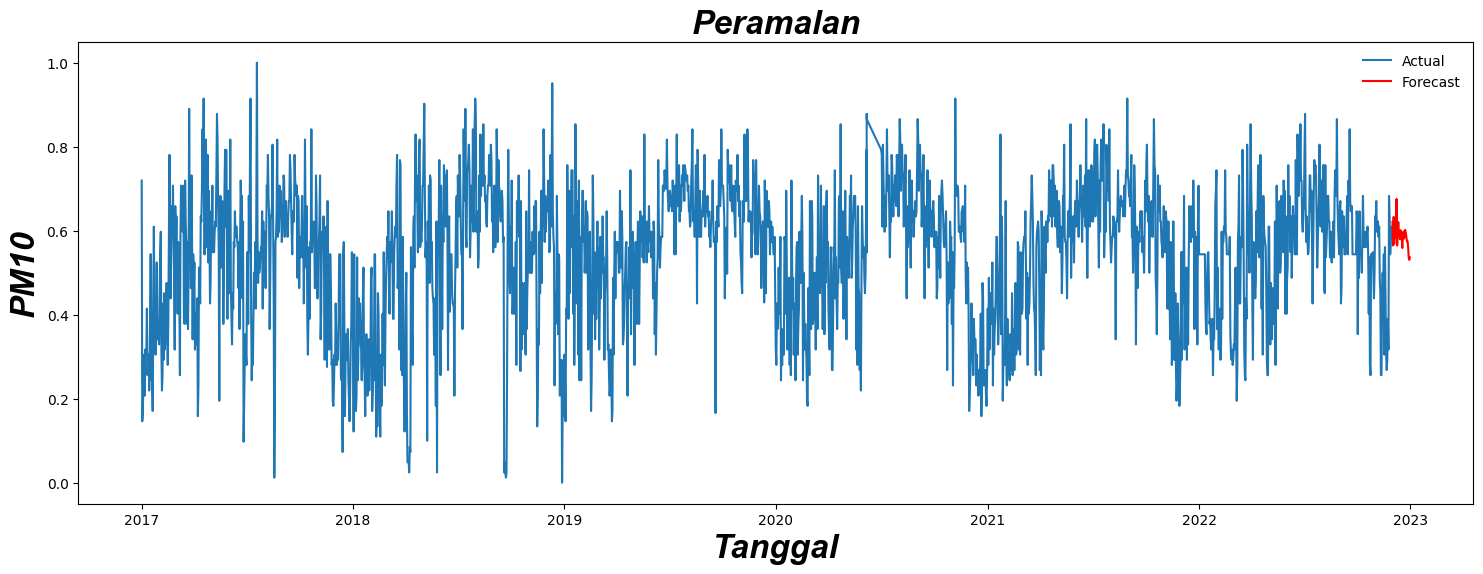

In [36]:
# Plot the actual data and forecasted values
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot_date(DKI1['Tanggal'], y, '-', label='Actual')
forecast_dates = DKI1['Tanggal'].iloc[-1] + pd.to_timedelta(np.arange(1, forecast_horizon + 1), unit='D')
ax.plot_date(forecast_dates, forecast.flatten(), '-', color='red', label='Forecast')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Tanggal', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.ylabel('PM10', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title('Peramalan', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.show()

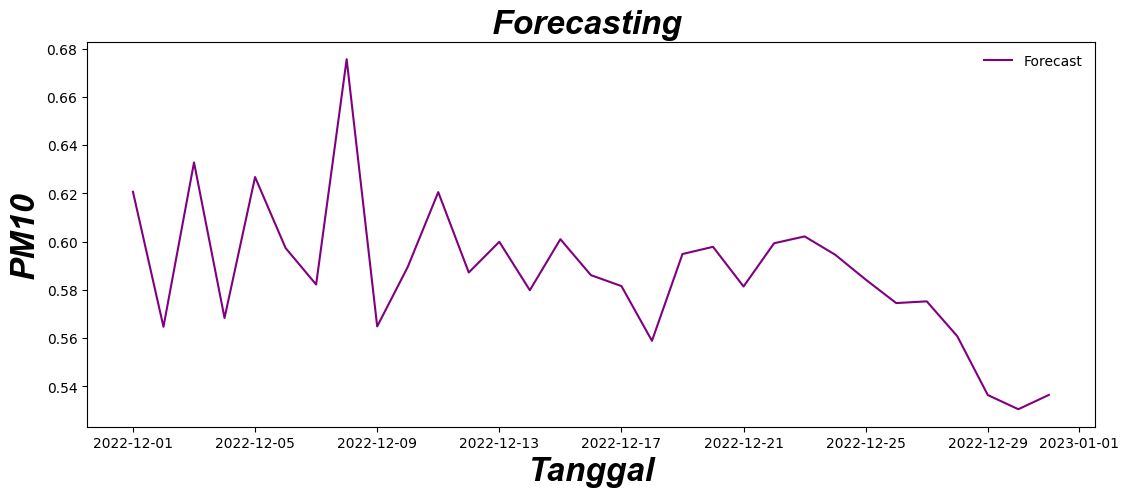

In [37]:
import matplotlib.pyplot as plt

# Plot the forecasted values
fig, ax = plt.subplots(figsize=(13, 5))
forecast_dates = DKI1['Tanggal'].iloc[-1] + pd.to_timedelta(np.arange(1, forecast_horizon + 1), unit='D')
ax.plot_date(forecast_dates, forecast.flatten(), '-', color='purple', label='Forecast')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Tanggal', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.ylabel('PM10', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title('Forecasting ', fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.show()


In [38]:
print (y_actual)

0     0.597561
1     0.731707
2     0.695122
3     0.695122
4     0.621951
5     0.609756
6     0.609756
7     0.536585
8     0.573171
9     0.439024
10    0.329268
11    0.268293
12    0.543846
13    0.543846
14    0.439024
15    0.543846
16    0.543846
17    0.543846
18    0.743902
19    0.543846
20    0.543846
21    0.543846
22    0.543846
23    0.543846
24    0.402439
25    0.390244
26    0.280488
27    0.256098
28    0.317073
29    0.560976
30    0.543846
Name: PM10, dtype: float64


In [39]:
# Create a DataFrame with 'Tanggal' and 'Forecast' columns
df_forecast = pd.DataFrame({
    'Tanggal': forecast_dates,
    'Forecast': forecast.flatten()
})

# Display the DataFrame
print(df_forecast)

      Tanggal  Forecast
0  2022-12-01  0.620699
1  2022-12-02  0.564702
2  2022-12-03  0.632876
3  2022-12-04  0.568364
4  2022-12-05  0.626813
5  2022-12-06  0.597365
6  2022-12-07  0.582244
7  2022-12-08  0.675688
8  2022-12-09  0.564863
9  2022-12-10  0.589497
10 2022-12-11  0.620557
11 2022-12-12  0.587226
12 2022-12-13  0.599954
13 2022-12-14  0.579867
14 2022-12-15  0.601031
15 2022-12-16  0.586127
16 2022-12-17  0.581597
17 2022-12-18  0.558876
18 2022-12-19  0.594884
19 2022-12-20  0.597874
20 2022-12-21  0.581421
21 2022-12-22  0.599356
22 2022-12-23  0.602190
23 2022-12-24  0.594610
24 2022-12-25  0.584286
25 2022-12-26  0.574537
26 2022-12-27  0.575261
27 2022-12-28  0.560811
28 2022-12-29  0.536397
29 2022-12-30  0.530512
30 2022-12-31  0.536443


In [40]:
# Mencari nilai terbesar dari kolom 'Forecast'
nilai_terbesar = df_forecast['Forecast'].max()

# Mencari nilai terkecil dari kolom 'Forecast'
nilai_terkecil = df_forecast['Forecast'].min()

# Menampilkan nilai terbesar dan terkecil
print("Nilai terbesar dari kolom 'Forecast':", nilai_terbesar)
print("Nilai terkecil dari kolom 'Forecast':", nilai_terkecil)


Nilai terbesar dari kolom 'Forecast': 0.6756876348913335
Nilai terkecil dari kolom 'Forecast': 0.5305120521659549


In [41]:
# Normalize train and test data
max_value = 100.0
min_value = 0.0
forecast_denorm = forecast.flatten() * (max_value - min_value) + min_value

# Convert the denormalized predicted values to a DataFrame
Forecast_denorm = pd.DataFrame({
    'Tanggal': forecast_dates,
    'Forecast': forecast_denorm  # Assuming you want to create a column named 'Forecast_denorm'
})

# Now you can print the DataFrame
print(Forecast_denorm)


      Tanggal   Forecast
0  2022-12-01  62.069949
1  2022-12-02  56.470250
2  2022-12-03  63.287552
3  2022-12-04  56.836407
4  2022-12-05  62.681334
5  2022-12-06  59.736483
6  2022-12-07  58.224408
7  2022-12-08  67.568763
8  2022-12-09  56.486325
9  2022-12-10  58.949680
10 2022-12-11  62.055653
11 2022-12-12  58.722557
12 2022-12-13  59.995386
13 2022-12-14  57.986726
14 2022-12-15  60.103120
15 2022-12-16  58.612654
16 2022-12-17  58.159676
17 2022-12-18  55.887646
18 2022-12-19  59.488450
19 2022-12-20  59.787389
20 2022-12-21  58.142142
21 2022-12-22  59.935567
22 2022-12-23  60.219044
23 2022-12-24  59.460963
24 2022-12-25  58.428581
25 2022-12-26  57.453714
26 2022-12-27  57.526059
27 2022-12-28  56.081072
28 2022-12-29  53.639703
29 2022-12-30  53.051205
30 2022-12-31  53.644279


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Mengubah data aktual ke dalam bentuk semula (sebelum dinormalisasi)
y_actual = (y_data[-forecast_horizon:] * sd_train) + mean_train

# Calculate evaluation metrics
rmse = math.sqrt(mean_squared_error(y_actual, forecast_denorm))
mse = mean_squared_error(y_actual, forecast_denorm)
mae = mean_absolute_error(y_actual, forecast_denorm)
r2 = r2_score(y_actual, forecast_denorm)
# Print the evaluation metrics
print('RMSE: %.3f' % rmse)
print('MSE: %.3f' % mse)
print('MAE: %.3f' % mae)
print('R-squared: %.3f' % r2)




RMSE: 58.312
MSE: 3400.347
MAE: 58.238
R-squared: -187171.152
